# **Open Food Facts Analysis Notebook**

This notebook demonstrates a data processing and recommendation system pipeline for the Open Food Facts dataset using Apache Spark on a Kaggle environment. It includes setup, data cleaning, feature engineering, and product recommendation based on ingredient similarity.

# 1. Environment Setup

Install and configure Java and Spark dependencies for a Kaggle notebook environment.

In [ ]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
spark= SparkSession \
       .builder \
       .appName("OpenFood") \
       .getOrCreate()
spark

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease     
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                     
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,553 kB]
Fetched 1,681 kB in 2s (1,089 kB/s)  
Reading package lists... Done
Building dependency tree... Done
Reading state information...

In [35]:
!pip install matplotlib seaborn wordcloud

# 2. Load Dataset

Read the Open Food Facts dataset from a CSV file with tab-separated values.

In [36]:
df = spark.read.csv("/kaggle/input/bigdata/en.openfoodfacts.org.products.csv", header=True, inferSchema=True, sep='\t')

# 3. Initial Data Exploration

Check the dataset size to understand its scale.

In [37]:
num_rows = df.count()
num_cols = len(df.columns)
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 3861422, Columns: 209


# 4. Initial Data Filtering

Filter rows with non-null critical fields and limit to 235,000 rows for memory efficiency.

In [38]:
from pyspark.sql.functions import col
#first filter out rows with critical missing data
df = df.filter(
    (col("product_name").isNotNull()) & 
    (col("ingredients_text").isNotNull()) & 
    (col("categories").isNotNull())
)

df = df.limit(235000)

#verify the count
print(f"Number of rows after limiting: {df.count()}")

Number of rows after limiting: 235000


In [39]:
df.select("countries").distinct().show(40, truncate=False)

+---------------------------------------+
|countries                              |
+---------------------------------------+
|Germany                                |
|Spanien, Germany                       |
|Brasil                                 |
|Griechenland, Germany                  |
|Brasilien, Germany                     |
|Frankreich, Germany                    |
|en:Switzerland                         |
|France                                 |
|en:France                              |
|Belgien, Germany                       |
|Germany, United States, en:france      |
|United States                          |
|FR                                     |
|en:Ireland                             |
|United Kingdom, en:france              |
|Belgium                                |
|spain                                  |
|en:Germany                             |
|Germany,en:germany                     |
|comidosil                              |
|brasil                           

# 5. Data Cleaning Function

Define a comprehensive data cleaning function optimized for Kaggle's memory constraints.

In [40]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, lit
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline

In [41]:
from pyspark.sql.functions import col, trim, lower, regexp_replace, lit, when, coalesce, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession

def clean_openfoodfacts_data(df):
    """
    Kaggle-optimized data cleaning function for Open Food Facts data 
    (without country treatment).
    
    Features:
    - Memory-efficient operations
    - Progressive filtering to reduce dataset size early
    - Kaggle-specific optimizations
    - Detailed logging for Kaggle notebooks
    """
    
    initial_count = df.count()
    print(f"Initial dataset size: {initial_count:,} records")
    
    #Column Selection
    relevant_columns = [
        'product_name', 'brands', 'categories', 
        'countries', 'ingredients_text', 'allergens', 
        'nutriscore_score', 'nutriscore_grade', 
        'energy_100g', 'fat_100g', 'saturated-fat_100g', 
        'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 
        'proteins_100g', 'salt_100g', 'image_url'
    ]
    available_columns = [c for c in relevant_columns if c in df.columns]
    df = df.select(available_columns)
    print(f"Selected {len(available_columns)} columns")
    
    #Early Filtering
    df = df.filter(
        col("product_name").isNotNull() |
        col("ingredients_text").isNotNull() |
        col("categories").isNotNull()
    )
    df = df.filter(
        col("product_name").isNotNull() &
        col("ingredients_text").isNotNull() &
        (col("ingredients_text") != "") &
        col("categories").isNotNull()
    )
    
    post_filter_count = df.count()
    print(f"After mandatory filters: {post_filter_count:,} records ({post_filter_count/initial_count:.1%} retained)")
    
    #text Cleaning
    text_columns = [c for c in ['product_name', 'ingredients_text', 'categories', 
                                'countries', 'allergens', 'generic_name', 'brands'] 
                    if c in df.columns]
    for col_name in text_columns:
        df = df.withColumn(col_name, 
            regexp_replace(
                regexp_replace(
                    trim(lower(col(col_name))),
                    "[^a-zA-Z0-9\\s-]", ""),
                "\\s+", " "))
        df = df.withColumn(col_name, 
            when((col(col_name) == "") | (col(col_name).isNull()), None)
            .otherwise(col(col_name)))
    
    df = df.filter(col("ingredients_text").isNotNull())
    
    #Numerical Imputation
    numerical_cols = [c for c in [
        'nutriscore_score', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
        'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'
    ] if c in df.columns]
    
    sample_frac = 0.1
    numerical_medians = {}
    for col_name in numerical_cols:
        try:
            median_value = df.sample(fraction=sample_frac).stat.approxQuantile(col_name, [0.5], 0.01)[0]
            numerical_medians[col_name] = median_value
        except:
            numerical_medians[col_name] = 0.0
    
    print("Median values for imputation:")
    for k, v in numerical_medians.items():
        print(f"- {k}: {v:.2f}")
    
    for col_name, median_value in numerical_medians.items():
        df = df.withColumn(col_name, 
            coalesce(col(col_name).cast(DoubleType()), lit(median_value)))
    
    #Deduplication
    df = df.dropDuplicates()
    if 'code' in df.columns and 'product_name' in df.columns:
        windowSpec = Window.partitionBy("product_name", "brands").orderBy(col("code").desc())
        df = df.withColumn("row_num", row_number().over(windowSpec))
        df = df.filter(col("row_num") == 1).drop("row_num")
    
    if "allergens" in df.columns:
        df = df.withColumn("allergens", 
            when(col("allergens").isNull(), lit("unknown")).otherwise(col("allergens")))
    
    final_count = df.count()
    print(f"Final cleaned dataset: {final_count:,} records ({final_count/initial_count:.1%} of original)")
    
    return df

df = clean_openfoodfacts_data(df).cache()

Initial dataset size: 235,000 records
Selected 17 columns


After mandatory filters: 235,000 records (100.0% retained)


Median values for imputation:
- nutriscore_score: 13.00
- energy_100g: 1142.00
- fat_100g: 4.58
- saturated-fat_100g: 1.41
- carbohydrates_100g: 24.24
- sugars_100g: 6.00
- fiber_100g: 1.30
- proteins_100g: 4.42
- salt_100g: 0.36


Final cleaned dataset: 228,361 records (97.2% of original)


In [42]:
df.count()

228361

In [43]:
df.select("countries").distinct().show(20, truncate=False)

+--------------------+
|countries           |
+--------------------+
|brasilien germany   |
|frankreich germany  |
|enfrance            |
|fr                  |
|france              |
|franciaespaa        |
|germany             |
|belgium             |
|united kingdom      |
|united states       |
|india               |
|brasile             |
|argentina           |
|espaa               |
|franceespagne       |
|frankreich          |
|francetats-unis     |
|enunited kingdom    |
|stati uniti damerica|
|ireland             |
+--------------------+
only showing top 20 rows



In [44]:
df = df.dropna(subset=["product_name", "categories", "nutriscore_grade"])
df = df.fillna({"brands": "Not specified"})
df = df.fillna({"countries" : "Not specified"})

In [45]:
numerical_cols = ['nutriscore_score', 'energy_100g', 'fat_100g', 'sugars_100g']
df.select(numerical_cols).describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|  nutriscore_score|       energy_100g|         fat_100g|      sugars_100g|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            228333|            228333|           228333|           228333|
|   mean|12.012437974362006|1668.7419376880305|  16.577266595995|19.77285818307647|
| stddev|10.105153016963412|   87584.751513345|43.59719551130757|46.06633652360065|
|    min|             -17.0|               0.0|              0.0|            -1.45|
|    max|              55.0|           4.184E7|           1670.0|           1900.0|
+-------+------------------+------------------+-----------------+-----------------+



In [46]:
from pyspark.sql.functions import col, sum

#calculate null counts per column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show(vertical=True)

-RECORD 0--------------------
 product_name       | 0      
 brands             | 0      
 categories         | 0      
 countries          | 0      
 ingredients_text   | 0      
 allergens          | 0      
 nutriscore_score   | 0      
 nutriscore_grade   | 0      
 energy_100g        | 0      
 fat_100g           | 0      
 saturated-fat_100g | 0      
 carbohydrates_100g | 0      
 sugars_100g        | 0      
 fiber_100g         | 0      
 proteins_100g      | 0      
 salt_100g          | 0      
 image_url          | 164356 



# 6. Exploratory Data Analysis (EDA)

affeter cleaning 

In [47]:
from pyspark.sql.functions import split, explode, trim

#explode allergens into separate rows
allergen_df = (
    df
    .filter(col("allergens").isNotNull())
    .withColumn("allergen", explode(split(col("allergens"), ",")))
    .withColumn("allergen", trim(col("allergen")))
    .filter(col("allergen") != "")  # Remove any blank entries
)

In [48]:
allergen_counts = (
    allergen_df.groupBy("allergen")
    .count()
    .orderBy(col("count").desc())
)

In [49]:
top_n = 10  #top 10 allergies
allergen_pd = allergen_counts.limit(top_n).toPandas()


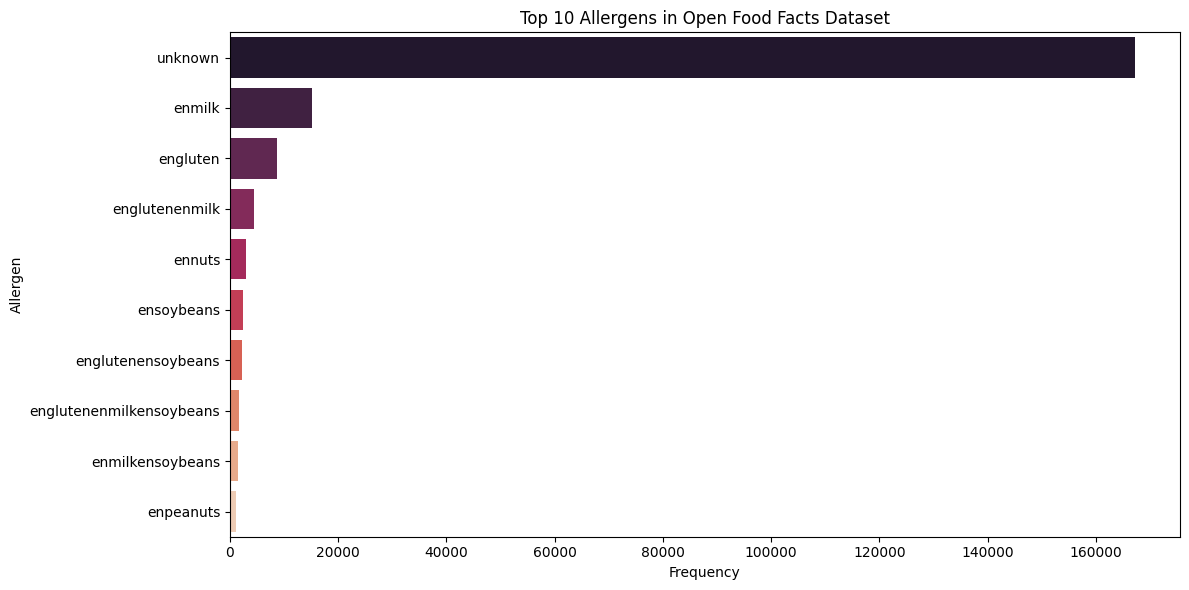

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=allergen_pd, x="count", y="allergen", palette="rocket")

plt.title(f"Top {top_n} Allergens in Open Food Facts Dataset")
plt.xlabel("Frequency")
plt.ylabel("Allergen")
plt.tight_layout()
plt.show()

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pyspark.sql.functions as F

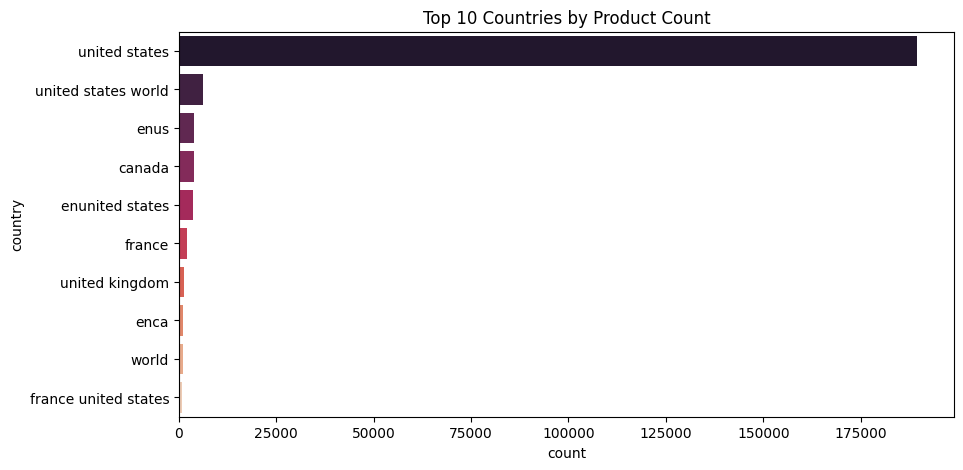

In [52]:
#split countries string and explode into rows
country_counts = df.withColumn("country", F.explode(F.split(F.lower("countries"), ","))) \
    .groupBy("country").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x="count", y="country", data=country_counts, palette="rocket")
plt.title("Top 10 Countries by Product Count")
plt.show()

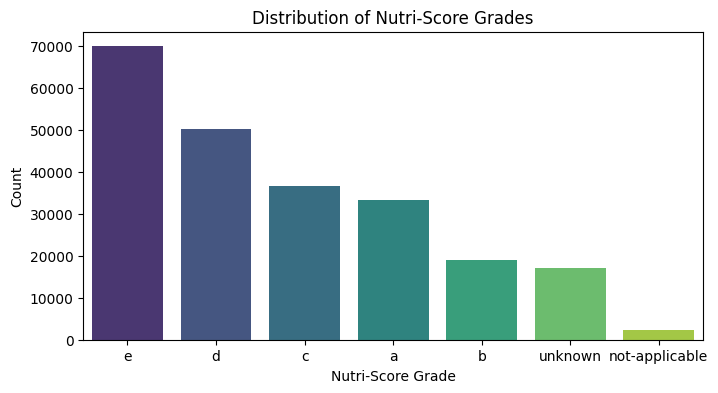

In [53]:
#group by Nutri-Score grade and count
nutri_counts = df.groupBy("nutriscore_grade").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(x="nutriscore_grade", y="count", data=nutri_counts, palette="viridis")
plt.title("Distribution of Nutri-Score Grades")
plt.xlabel("Nutri-Score Grade")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

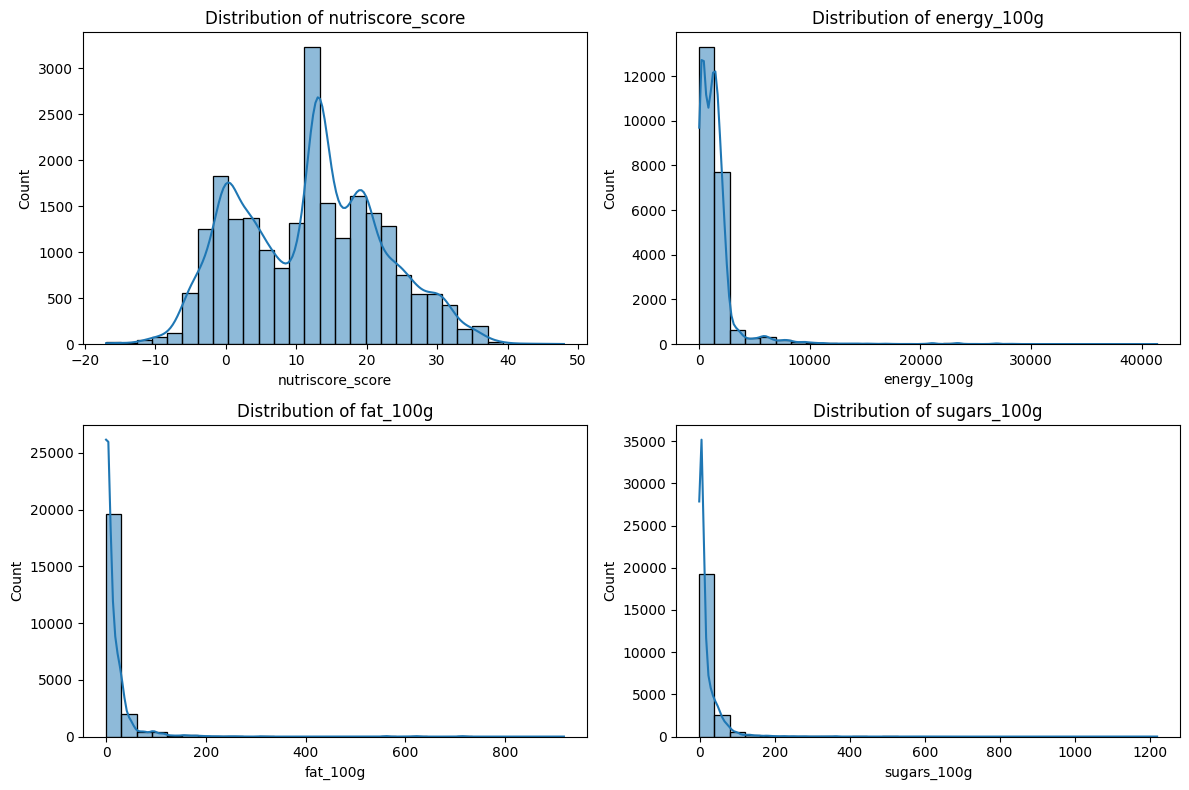

In [54]:
#sample a fraction of data for plotting (for performance)
sample_df = df.select(numerical_cols).sample(0.1).toPandas()

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(sample_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [55]:
from pyspark.ml import Transformer, Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, Normalizer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('punkt')

SYNONYMS = {
    "mozzarella": "cheese", "cheddar": "cheese", "parmesan": "cheese",
    "tomatoes": "tomato", "wheat": "flour", "corn": "flour"
}

#custom filter to remove non-ingredient words
def is_ingredient_token(token):
    return (len(token) > 2 and 
            not token.isnumeric() and 
            not re.match(r'^[0-9\.-]+$', token) and
            not token in ['gmbh', 'wwwknorrde', 'unilever'])

#fixed SynonymReplacer
class SynonymReplacer(Transformer, HasInputCol, HasOutputCol):
    def __init__(self, synonyms=None, inputCol=None, outputCol=None):
        super(SynonymReplacer, self).__init__()
        self.synonyms = synonyms or {}
        self._setDefault(inputCol=inputCol)
        self._setDefault(outputCol=outputCol)
    
    def _transform(self, dataset):
        def replace_synonyms(tokens):
            return [self.synonyms.get(token, token) for token in tokens if is_ingredient_token(token)]
        
        replace_udf = udf(replace_synonyms, ArrayType(StringType()))
        return dataset.withColumn(self.getOutputCol(), replace_udf(col(self.getInputCol())))

#optimized pipeline
pipeline = Pipeline(stages=[
    Tokenizer(inputCol="ingredients_text", outputCol="tokens"),
    SynonymReplacer(synonyms=SYNONYMS, inputCol="tokens", outputCol="filtered_tokens"),
    CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features", minDF=5.0),  # Increased minDF
    IDF(inputCol="raw_features", outputCol="features"),
    Normalizer(inputCol="features", outputCol="norm_features", p=2.0)
])

#fit and transform
model = pipeline.fit(df)
df = model.transform(df).cache()

print("Optimized vocabulary size:", len(model.stages[2].vocabulary))
df.select("product_name", "ingredients_text", "filtered_tokens", "norm_features").show(5, truncate=False)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Optimized vocabulary size: 9291


25/06/02 19:37:17 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 253.4 MiB so far)
25/06/02 19:37:17 WARN BlockManager: Persisting block rdd_459_0 to disk instead.
25/06/02 19:37:29 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)


+-----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

25/06/02 19:37:30 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)


In [56]:
df.columns

['product_name',
 'brands',
 'categories',
 'countries',
 'ingredients_text',
 'allergens',
 'nutriscore_score',
 'nutriscore_grade',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'image_url',
 'tokens',
 'filtered_tokens',
 'raw_features',
 'features',
 'norm_features']

# 7. Cosine Similarity UDF

Define a user-defined function (UDF) to compute cosine similarity between feature vectors.

In [57]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import SparseVector, DenseVector
import numpy as np

@udf(DoubleType())
def cosine_similarity(v1, v2):
    try:
        # Handle None or invalid vectors
        if v1 is None or v2 is None:
            return 0.0
        
        # Convert v1 to dense array
        v1_array = v1.toArray() if isinstance(v1, SparseVector) else np.array(v1)
        
        # Convert v2 to dense array
        v2_array = v2.toArray() if isinstance(v2, SparseVector) else np.array(v2)
        
        # Ensure vectors have the same length
        if v1_array.shape != v2_array.shape:
            return 0.0
        
        # Check for zero vectors to avoid division by zero
        if np.all(v1_array == 0) or np.all(v2_array == 0):
            return 0.0
        
        # Compute cosine similarity (dot product of L2-normalized vectors)
        dot_product = float(np.dot(v1_array, v2_array))
        return dot_product
    except Exception as e:
        print(f"Error in cosine similarity: {str(e)}")
        return 0.0  # Return 0.0 for invalid or empty vectors

# 8. Recommendation Function

Define a recommendation function that suggests products based on ingredient similarity, with optional filters for country, nutriscore, and allergens.

In [58]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

def get_recommendations(
    ingredient_list=None,  #changed to match parameter name
    ingredients=None,      #n,ew alias for compatibility
    country=None, 
    nutriscore=None, 
    allergens=None, 
    top_n=5, 
    similarity_threshold=0.1,
    relax_filters=False,
    recursion_depth=0,  #new parameter to track recursion
    max_recursion=3    #maximum recursion depth
):
    
    #handle both parameter names
    if ingredients is not None:
        ingredient_list = ingredients
    elif ingredient_list is None:
        raise ValueError("Must provide either 'ingredient_list' or 'ingredients'")
    
    #validate input
    if not ingredient_list:
        raise ValueError("Ingredient list cannot be empty")
    
    #process input
    input_text = " ".join([
        SYNONYMS.get(ing.lower().strip(), ing.lower().strip()) 
        for ing in ingredient_list
    ])
    
    #create input DataFrame
    input_df = spark.createDataFrame(
        [(input_text,)], 
        schema=["ingredients_text"]
    )
    
    input_processed = model.transform(input_df)
    input_vec = input_processed.select("norm_features").first()[0]
    
    #convert input_vec to dense array and broadcast
    input_vec_array = input_vec.toArray() if isinstance(input_vec, SparseVector) else np.array(input_vec)
    broadcast_vec = spark.sparkContext.broadcast(input_vec_array)
    
    #apply filters
    filtered_df = df
    if country:
        filtered_df = filtered_df.filter(lower(col("countries")).contains(country.lower()))
    if nutriscore:
        filtered_df = filtered_df.filter(lower(col("nutriscore_grade")) == nutriscore.lower())
    if allergens and 'allergens' in df.columns:
        for allergen in allergens:
            filtered_df = filtered_df.filter(
                col("allergens").isNull() | 
                ~lower(col("allergens")).contains(allergen.lower())
            )
    
    #calculate similarities using UDF
    recommendations = filtered_df.withColumn(
        "similarity", 
        cosine_similarity(col("norm_features"), lit(broadcast_vec.value.tolist()))
    ).filter(col("similarity") >= similarity_threshold)
    
    #fallback if no results
    if recommendations.count() == 0 and relax_filters and recursion_depth < max_recursion:
        print(f"No results with strict filters, relaxing constraints (depth {recursion_depth + 1})...")
        return get_recommendations(
            ingredient_list=ingredient_list,
            country=country,
            nutriscore=None if recursion_depth >= 1 else nutriscore,  # Relax nutriscore after first recursion
            allergens=None if recursion_depth >= 1 else allergens,    # Relax allergens after first recursion
            top_n=top_n,
            similarity_threshold=max(0.05, similarity_threshold/2),
            relax_filters=relax_filters,
            recursion_depth=recursion_depth + 1,  # Increment depth
            max_recursion=max_recursion
        )
    
    #return empty DataFrame or message if no results after max recursion
    if recommendations.count() == 0:
        print(f"No recommendations found after {recursion_depth} relaxation attempts.")
        return spark.createDataFrame([], schema=df.schema)
    
    return recommendations.orderBy(col("similarity").desc()).limit(top_n)

# 9. Test Recommendations

Run test cases to evaluate the recommendation function.

In [59]:
test_cases = [
    {"ingredient_list": ["tomato", "cheese"], "country": "France"},
    {"ingredient_list": ["flour", "eggs"], "nutriscore": "a", "allergens": ["gluten"]},
    {"ingredient_list": ["chocolate"], "country": "Belgium", "similarity_threshold": 0.2}
]

for idx, case in enumerate(test_cases, 1):
    print(f"\nTest Case {idx}: {case}")
    try:
        recs = get_recommendations(**case, relax_filters=True)
        if recs and recs.count() > 0:
            recs.select(
                "product_name", 
                "brands", 
                "countries",
                "nutriscore_grade", 
                "similarity"
            ).show(truncate=False)
        else:
            print("No recommendations found")
    except Exception as e:
        print(f"Error: {str(e)}")


Test Case 1: {'ingredient_list': ['tomato', 'cheese'], 'country': 'France'}


25/06/02 19:37:42 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:37:59 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:38:17 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:38:35 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)


+------------------------------------+-------------------------------+----------------------+----------------+------------------+
|product_name                        |brands                         |countries             |nutriscore_grade|similarity        |
+------------------------------------+-------------------------------+----------------------+----------------+------------------+
|tomato pesto pasta sauce            |classico                       |francecanada          |a               |0.6007953880115747|
|roasted garlic chunky salsa medium  |tostitos                       |france united states  |b               |0.5574515628673135|
|comt                                |marks spencer marks and spencer|france                |d               |0.5195320117451647|
|medium salsa                        |pepsi tostitos                 |canadafrance          |b               |0.5133478442904571|
|tomato juice from concentrate tomato|Not specified                  |enfrance united stat

25/06/02 19:39:03 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:40:16 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:41:29 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:42:49 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)


+------------------------+------------------+----------------+----------------+------------------+
|product_name            |brands            |countries       |nutriscore_grade|similarity        |
+------------------------+------------------+----------------+----------------+------------------+
|15 british barn eggs    |sainsburys        |united kingdom  |a               |0.9753922295819943|
|cage-free eggs          |trader joes       |united states   |a               |0.9753922295819943|
|grade a large white eggs|green valley farms|united states   |a               |0.9753922295819943|
|grade a large eggs      |kroger            |united states   |a               |0.9753922295819943|
|6 british large eggs    |ms                |enunited kingdom|a               |0.9753922295819943|
+------------------------+------------------+----------------+----------------+------------------+


Test Case 3: {'ingredient_list': ['chocolate'], 'country': 'Belgium', 'similarity_threshold': 0.2}


25/06/02 19:44:19 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)


No results with strict filters, relaxing constraints (depth 1)...


25/06/02 19:44:31 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:44:32 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:44:34 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)
25/06/02 19:44:35 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 440.5 MiB so far)


+-----------------------------+------------------+---------+----------------+-------------------+
|product_name                 |brands            |countries|nutriscore_grade|similarity         |
+-----------------------------+------------------+---------+----------------+-------------------+
|rocky road original candy bar|annabelle candy co|enbelgium|unknown         |0.1330758239521472 |
|rocky road smore             |annabelles        |enbelgium|d               |0.12007184418736729|
+-----------------------------+------------------+---------+----------------+-------------------+



# 10. Save Results

Save processed data and model assets for future use.

In [ ]:
import pandas as pd
df_pd = df.toPandas()
df_pd.to_pickle("food_data.pkl")

In [ ]:
import joblib 
# Save vocabulary and synonyms
vocab = model.stages[2].vocabulary  # Adjust index if necessary
joblib.dump({'vocab': vocab, 'synonyms': SYNONYMS}, "model_assets.pkl")

In [ ]:
# Save Spark DataFrame as JSON
df.write.mode("overwrite").json("/kaggle/working/recommend_data_json")